In [9]:
import sys
import os

# Go one level up from notebooks/ to project root
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))

print("Detected project root:", PROJECT_ROOT)

if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("Python path updated.")


Detected project root: c:\GitHub\marked-point-invariance-failure
Python path updated.


In [10]:
import numpy as np
import matplotlib.pyplot as plt

from generate_data import generate_sample


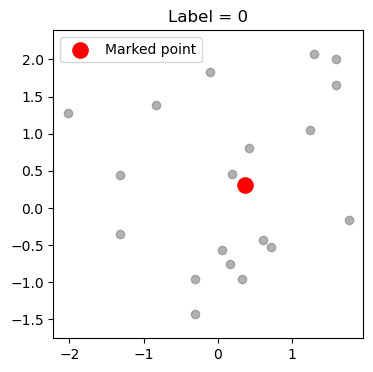

In [12]:
pts, marked_idx, label = generate_sample(n_points=20)

plt.figure(figsize=(4, 4))
plt.scatter(pts[:, 0], pts[:, 1], c="gray", alpha=0.6)
plt.scatter(
    pts[marked_idx, 0],
    pts[marked_idx, 1],
    c="red",
    s=120,
    label="Marked point"
)

plt.title(f"Label = {label}")
plt.legend()
plt.axis("equal")
plt.show()


In [13]:
def permute_points(pts, marked_idx):
    perm = np.random.permutation(len(pts))
    pts_perm = pts[perm]
    marked_perm = np.where(perm == marked_idx)[0][0]
    return pts_perm, marked_perm


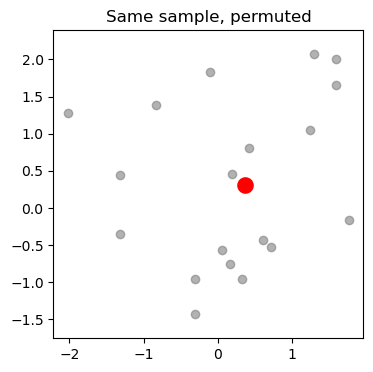

In [14]:
pts_p, marked_p = permute_points(pts, marked_idx)

plt.figure(figsize=(4, 4))
plt.scatter(pts_p[:, 0], pts_p[:, 1], c="gray", alpha=0.6)
plt.scatter(
    pts_p[marked_p, 0],
    pts_p[marked_p, 1],
    c="red",
    s=120,
    label="Marked point (permuted)"
)

plt.title("Same sample, permuted")
plt.axis("equal")
plt.show()


In [15]:
import torch
import torch.nn as nn

class BadEncoder(nn.Module):
    def __init__(self, hidden=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden)
        )

    def forward(self, x):
        # x: (N, 2)
        h = self.net(x)
        return h.flatten()  # ORDER-DEPENDENT


In [16]:
encoder = BadEncoder()
encoder.eval()

with torch.no_grad():
    z1 = encoder(torch.tensor(pts, dtype=torch.float))
    z2 = encoder(torch.tensor(pts_p, dtype=torch.float))

dist = torch.norm(z1 - z2).item()
print("Embedding distance after permutation:", dist)


Embedding distance after permutation: 7.897462368011475


In [17]:
class InvariantEncoder(nn.Module):
    def __init__(self, hidden=32):
        super().__init__()
        self.phi = nn.Sequential(
            nn.Linear(2, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden)
        )

    def forward(self, x):
        h = self.phi(x)          # (N, hidden)
        return h.mean(dim=0)     # permutation-invariant


In [18]:
inv_encoder = InvariantEncoder()
inv_encoder.eval()

with torch.no_grad():
    z1_inv = inv_encoder(torch.tensor(pts, dtype=torch.float))
    z2_inv = inv_encoder(torch.tensor(pts_p, dtype=torch.float))

dist_inv = torch.norm(z1_inv - z2_inv).item()
print("Invariant encoder distance after permutation:", dist_inv)


Invariant encoder distance after permutation: 7.803682677831603e-08


In [19]:
# Same point cloud, different marked point
pts2 = pts.copy()
marked_idx_alt = (marked_idx + 1) % len(pts2)

# swap points to simulate different marking
pts2[[marked_idx, marked_idx_alt]] = pts2[[marked_idx_alt, marked_idx]]

with torch.no_grad():
    z_orig = inv_encoder(torch.tensor(pts, dtype=torch.float))
    z_alt  = inv_encoder(torch.tensor(pts2, dtype=torch.float))

print("Invariant encoder distance (different marked point):",
      torch.norm(z_orig - z_alt).item())


Invariant encoder distance (different marked point): 0.0


In [ ]:
bad_dist = dist
inv_dist = dist_inv

plt.bar(["Order-sensitive", "Permutation-invariant"],
        [bad_dist, inv_dist])

plt.ylabel("Embedding distance after permutation")
plt.title("Permutation Sensitivity of Encoders")
plt.show()
